In [1]:
from selenium import webdriver
from selenium.webdriver import ActionChains
from selenium.webdriver.common.by import By

import cv2

import time

import numpy as np
import matplotlib.pyplot as plt

In [2]:
import sys
sys.path.insert(0, '..')

from web_interaction.main import open_game, start_game
from game.game import ProductOwnerGame
from game.userstory_card.userstory_card_info import UserStoryCardInfo
from environment.backlog_env import BacklogEnv
from environment.environment import ProductOwnerEnv
from environment.reward_sytem.base_reward_system import BaseRewardSystem
from environment.userstory_env import UserstoryEnv
import image_parser

from pipeline.study_agent import load_dqn_agent
from single_color_storage import SingleColorStorage

In [3]:
driver = open_game()

In [4]:
time.sleep(10)

In [5]:
iframe = driver.find_element(by=By.ID, value='game_drop')
height = iframe.rect["height"]  # 540
width = iframe.rect["width"]  # 960

In [6]:
start_game(driver, iframe)

In [10]:
# buy research
ActionChains(driver).move_to_element_with_offset(
    iframe, int(0.3 * width), -int(0.3 * height)
).click().perform()

In [31]:
iframe.screenshot('iframe.png')

True

In [10]:
image = cv2.imread('iframe.png')
meta_info = image[7:83, 57:932]

In [4]:
game = ProductOwnerGame()
context = game.context

context.is_new_game = False

In [5]:
current_sprint = image_parser.get_sprint_number(meta_info)
context.current_sprint = current_sprint
current_sprint

4.0

In [6]:
available_developers_count = 2
current_rooms_counter = 1
blank_sprint_counter = 0

In [7]:
current_sprint_hours = image_parser.get_current_sprint_hours(image)
current_sprint_hours

2.0

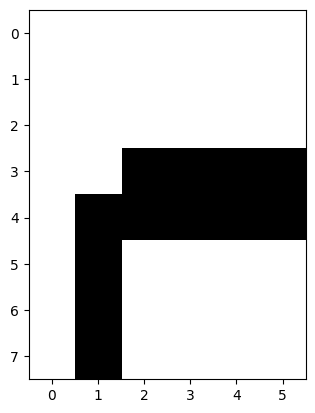

ValueError: could not convert string to float: ''

In [8]:
user_stories, positions = image_parser.get_user_stories(image)
user_stories, positions

In [14]:
for user_story, position in zip(user_stories, positions):
    color, loyalty, customers = user_story
    color_storage = SingleColorStorage(color)
    game_user_story = UserStoryCardInfo('S', current_sprint, color_storage)
    game_user_story.loyalty = loyalty
    game_user_story.customers_to_bring = customers
    game_user_story.position = position

    game.userstories.add_us(game_user_story)

In [39]:
money = image_parser.get_game_money(meta_info)
context.set_money(money)

loyalty = image_parser.get_loyalty(meta_info)
context.set_loyalty(loyalty)

context.customers = image_parser.get_customers(meta_info)

In [40]:
credit = max(300_000 - (current_sprint - 1) * 9_000, 0)
context.credit = credit
credit

273000.0

In [11]:
backlog_cards = image_parser.get_backlog(image)
backlog_cards

[(array([120,  79, 240], dtype=uint8), 17.0),
 (array([120,  79, 240], dtype=uint8), 8.0),
 (array([120,  79, 240], dtype=uint8), 8.0),
 (array([120,  79, 240], dtype=uint8), 5.0)]

In [ ]:
# gruop cards by color
# find user story card
# clear user story related cards
# fill user story with new related cards

In [17]:
from operator import itemgetter
from itertools import groupby
from typing import Tuple, Sequence, FrozenSet

from game.backlog_card.card_info import CardInfo
from game.userstory_card.userstory_card import UserStoryCard

def key_func(card: Tuple[list, float]):
    return frozenset(enumerate(card[0]))

def find_user_story_by_color(user_stories: Sequence[UserStoryCard], color: FrozenSet[Tuple[int, int]]):
    for user_story in user_stories:
        if frozenset(enumerate(user_story.info.color)) == color:
            return user_story

for key, group in groupby(backlog_cards, key_func):
    print(key, group)
    # user_story: UserStoryCard = find_user_story_by_color()
    # if user_story is None:
    #     continue
    # user_story.info.related_cards.clear()
    for image_card in group:
        color, hours = image_card
        print(image_card)
        card_info = CardInfo(hours_val=hours, color_val=key, us_id_val=None, label_val=None, card_type_val=None)

frozenset({(1, 79), (0, 120), (2, 240)}) <itertools._grouper object at 0x000001ED7646B310>
(array([120,  79, 240], dtype=uint8), 17.0)
(array([120,  79, 240], dtype=uint8), 8.0)
(array([120,  79, 240], dtype=uint8), 8.0)
(array([120,  79, 240], dtype=uint8), 5.0)


In [17]:
userstory_env = UserstoryEnv(2, 0, 0)
backlog_env = BacklogEnv(6, 0, 0, 6, 0, 0)
reward_system = BaseRewardSystem(config={})
env = ProductOwnerEnv(userstory_env, backlog_env, with_info=True, reward_system=reward_system)
env.game = game

In [27]:
state = env._get_state()
state

array([ 4.  ,  0.33, 25.  ,  4.  ,  2.73,  2.  ,  1.  ,  0.  ,  0.  ,
        0.  ,  1.  ,  0.  ,  1.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ], dtype=float32)

In [28]:
info = env.get_info()
info

{'actions': [0, 1]}

In [20]:
agent = load_dqn_agent('../models/credit_start_model.pt')

In [29]:
action = agent.get_action(state, info)
action

1

In [23]:
card_info = userstory_env.userstories_common[action - 7].info
card_info.color

array([120,  79, 240], dtype=uint8)

In [24]:
card_info.position

(725, 183)

In [25]:
time.sleep(5)
# move user story
x, y = card_info.position
ActionChains(driver).move_to_element_with_offset(
    iframe, x - width // 2 + 10, y - height // 2 + 5
).click().perform()

In [26]:
env._perform_action(action)
env._get_state()

array([ 4.  ,  0.33, 25.  ,  4.  ,  2.73,  2.  ,  1.  ,  0.  ,  0.  ,
        0.  ,  1.  ,  0.  ,  1.  ,  1.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,  0.  ,
        0.  ,  0.  ,  0.  ], dtype=float32)

In [30]:
time.sleep(5)
# decompose
ActionChains(driver).move_to_element_with_offset(
    iframe, 817 - width // 2, 480 - height // 2
).click().perform()

In [13]:
iframe.rect

{'height': 540, 'width': 960, 'x': 29.600000381469727, 'y': 20}

In [25]:
driver.quit()